<span style="font-size: 48px; font-weight: bold;">Algorytm BOGP testowany na zbiorze CIFAR-10</span>

Spis treści

- [1](#1)- Zainstalowanie wymaganych pakietów
- [2](#2) - Zaimportowanie bibliotek np.numpy, keras, skopt, tensorflow
- [3](#3) - Załadowanie danych
- [4](#4) - Ocena zbalansowania zbioru
- [5](#5) - Normalizacja danych
- [6](#6)- Zdefiniowanie CNN
- [7](#7) - Zdefiniowanie przestrzeni hiperparametrów i umieszczenie hiperparametrów na liście
- [8](#8) - Zdefiniowa funkcji celu
- [9](#9) - Zdefiniowanie parametrów startowych
- [10](#10) - Wykonanie proces optymalizacji bayesowskiej za pomocą funkcji `gp_minimize`
- [11](#11) - Wyświetlenie najlepszych wyników
- [12](#12) - Wykres konwergencji
- [13](#13) - Wykres wartość funkcji celu w każdej iteracji
- [14](#14) - Wykres plot_objective
- [15](#15) - Wykres plot evaluations
- [16](#16) - Macierz pomyłek
- [17](#17) - Ocena modelu na zbiorze testowym

### <a name='1'></a> 1. Zainstalowanie wymaganych pakietów

In [1]:
# !pip install scikit-learn
# !pip install scikit-optimize
# !pip install keras
# !pip install numpy

### <a name="2"></a> 2. Zaimportowanie bibliotek np.numpy, keras, skopt, tensorflow

In [2]:
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D,MaxPooling2D, BatchNormalization, Dropout
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

from skopt import gp_minimize
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_convergence
from skopt.plots import plot_objective, plot_evaluations
from skopt.utils import use_named_args

import tensorflow as tf
from tensorflow.keras.datasets import cifar10

In [3]:
import time

### <a name="3"></a> 3.Załadowanie danych


In [4]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [5]:
y_train = y_train.flatten() 
y_test = y_test.flatten()

### <a name="4"></a> 4.Ocena zbalansowania zbioru

Text(0, 0.5, 'Number of images')

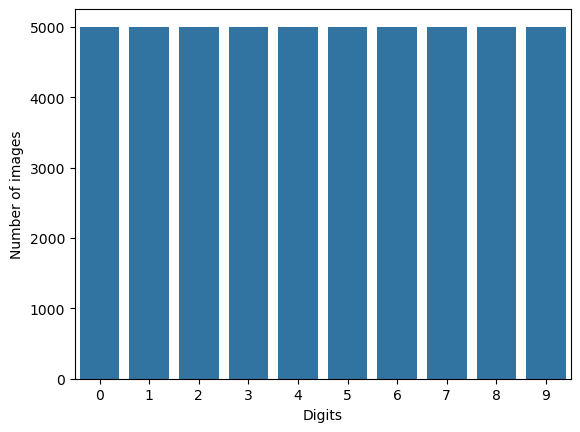

In [6]:
g = sns.countplot(x=y_train)
plt.xlabel('Digits')
plt.ylabel('Number of images')

### <a name="5"></a> 5. Normalizacja danych

In [7]:
X_train = X_train / 255.0
X_test = X_test / 255.0


y_train = to_categorical(y_train, num_classes = 10)
y_test = to_categorical(y_test, num_classes = 10)

### <a name="6"></a> 6.Zdefiniowanie CNN

In [8]:
def create_cnn(
    learning_rate,
    num_dense_layers,
    num_dense_nodes,
    num_conv_layers,
    filter_size,
    kernel_size,
    activation,
):
    """
    Hiperparametry:
    learning_rate: Współczynnik uczenia dla optymalizatora.
    num_dense_layers: Liczba warstw gęstych (dense).
    num_dense_nodes: Liczba neuronów w każdej warstwie gęstej.
    num_conv_layers: Liczba warstw konwolucyjnych
    filter_size: Liczba filtrów w warstwach konwolucyjnych.
    kernel_size: Rozmiar kernela.
    activation: Funkcja aktywacji dla wszystkich warstw.
    """

    model = Sequential()

    
    for i in range(num_conv_layers):
        filters = filter_size + (15*i)
        model.add(Conv2D(kernel_size=kernel_size, strides=1, filters=filter_size, padding='same',
                     activation=activation))
        model.add(BatchNormalization())
        model.add(MaxPool2D(pool_size=2, strides=2))

    model.add(Dropout(0.25))

    model.add(Flatten()) 

    for i in range(num_dense_layers):

        model.add(Dense(num_dense_nodes,
                        activation=activation,
                        ))


    model.add(Dense(10, activation='sigmoid')) 
    
    optimizer = Adam(learning_rate=learning_rate)

    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])

    return model

### <a name="7"></a> 7.Zdefiniowanie przestrzeni hiperparametrów i umieszczenie hiperparametrów na liście

In [9]:
dim_learning_rate = Real(
    low=1e-6, high=1e-2, prior='log-uniform', name='learning_rate',
)

dim_num_dense_layers = Integer(low=1, high=5, name='num_dense_layers')

dim_num_dense_nodes = Integer(low=10, high=500, name='num_dense_nodes')

dim_num_conv_layers = Integer(low=2, high=5, name='num_conv_layers')
dim_filter_size = Categorical(categories=[16, 32, 64, 128], name='filter_size')
dim_kernel_size = Categorical(categories=['(3,3)', '(5,5)', '(7,7)'], name='kernel_size')

dim_activation = Categorical(
    categories=['relu', 'sigmoid'], name='activation',
)


param_grid = [
    dim_learning_rate,
    dim_num_dense_layers,
    dim_num_dense_nodes,
    dim_num_conv_layers,
    dim_filter_size,
    dim_kernel_size,
    dim_activation,
]

### <a name="8"></a> 8.Zdefiniowa funkcji celu

In [10]:
# model zapisany pod nazwą
path_best_model = 'cnn_model.h5'

# punkt startowy dla optymalizacji
best_accuracy = 0


@use_named_args(param_grid)
def objective(
    learning_rate,
    num_dense_layers,
    num_dense_nodes,
    num_conv_layers,
    filter_size,
    kernel_size,
    activation,
):

    """
    Hiperparametry:
    learning_rate: Współczynnik uczenia dla optymalizatora.
    num_dense_layers: Liczba warstw gęstych (dense).
    num_dense_nodes: Liczba neuronów w każdej warstwie gęstej.
    num_conv_layers: Liczba warstw konwolucyjnych
    filter_size: Liczba filtrów w warstwach konwolucyjnych.
    kernel_size: Rozmiar kernela.
    activation: Funkcja aktywacji dla wszystkich warstw.
    """

    if kernel_size == '(3,3)':
        kernel_size = (3,3)
    elif kernel_size == '(5,5)':
        kernel_size = (5,5)
    elif kernel_size == '(7,7)':
        kernel_size = (7,7)
        
    print('learning rate: {0:.1e}'.format(learning_rate))
    print('num_dense_layers:', num_dense_layers)
    print('num_dense_nodes:', num_dense_nodes)
    print('num_conv_layers:', num_conv_layers)
    print('filter_size:', filter_size)
    print('kernel_size:', kernel_size)
    print('activation:', activation)
    print()

    model = create_cnn(learning_rate=learning_rate,
                       num_dense_layers=num_dense_layers,
                       num_dense_nodes=num_dense_nodes,
                       num_conv_layers=num_conv_layers,
                       filter_size=filter_size,
                       kernel_size=kernel_size,
                       activation=activation)


    """
    Callback do redukcji współczynnika uczenia
    Automatycznie zmniejsza współczynnik uczenia (learning_rate) o factor=0.5, jeśli
    val_accuracy (dokładność na zbiorze walidacyjnym) nie poprawi się przez patience=2 epoki.
    Minimalny współczynnik uczenia to min_lr=0.00001."""
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                                patience=2,
                                                verbose=1,
                                                factor=0.5,
                                                min_lr=0.00001)

    history = model.fit(x=X_train,
                        y=y_train,
                        epochs=5,
                        batch_size=32,
                        validation_split=0.1,
                        callbacks=learning_rate_reduction)

    accuracy = history.history['val_accuracy'][-1]

    print()
    print("Accuracy: {0:.2%}".format(accuracy))
    print()

    #Aktualizacja najlepszego modelu
    global best_accuracy

    if accuracy > best_accuracy:
        model.save(path_best_model)

        best_accuracy = accuracy
    del model

    return -accuracy

### <a name="9 "></a> 9. Zdefiniowanie parametrów startowych

In [11]:
default_parameters = [1e-5, 1, 16,3,32,'(5,5)', 'relu']



### <a name="10"></a> 10. Wykonanie proces optymalizacji bayesowskiej za pomocą funkcji `gp_minimize`:

gdzie:
- **Przekazujemy:**
  - Funkcję celu (objective function),
  - Przestrzeń hiperparametrów (hyperparameter space),
  - Początkowe parametry: `x0` (lista z początkowymi wartościami hiperparametrów),
  - Funkcję akwizycji (acquisition function): domyślnie `"EI"` (Expected Improvement).
  - Liczbę próbek przestrzeni hiperparametrów: `n_calls=100`,
  - zmienną random_state ustawioną na 0 w celu reprodukowalności wyników


- **Cel:**
  Znalezienie optymalnych wartości hiperparametrów minimalizujących funkcję celu.

Biblioteka **skopt** wymaga określonej liczby punktów początkowych, które mogą być generowane losowo lub zdefiniowane w parametrze `x0`. 

Oprócz tego optymalizator wymaga dodatkowych wywołań do wyznaczania nowych punktów w przestrzeni hiperparametrów. Minimalna liczba wywołań to `n_calls >= 11`.

In [12]:
start_time = time.perf_counter() 
gp_ = gp_minimize(
    objective,
    param_grid, 
    x0=default_parameters, 
    acq_func='EI', 
    n_calls=100, 
    random_state=0,
)
end_time = time.perf_counter()
execution_time = end_time - start_time
print(f"Czas wykonania: {execution_time} sekund")

learning rate: 1.0e-05
num_dense_layers: 1
num_dense_nodes: 16
num_conv_layers: 3
filter_size: 32
kernel_size: (5, 5)
activation: relu

Epoch 1/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.1193 - loss: 0.6209 - val_accuracy: 0.1654 - val_loss: 0.4022 - learning_rate: 1.0000e-05
Epoch 2/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.1669 - loss: 0.4109 - val_accuracy: 0.2164 - val_loss: 0.3544 - learning_rate: 1.0000e-05
Epoch 3/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.2051 - loss: 0.3637 - val_accuracy: 0.2504 - val_loss: 0.3208 - learning_rate: 1.0000e-05
Epoch 4/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.2383 - loss: 0.3329 - val_accuracy: 0.3032 - val_loss: 0.3012 - learning_rate: 1.0000e-05
Epoch 5/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.2839 - loss: 0.3127 - val_accuracy: 0.3502 - val_loss: 0.2835 - learning_rate: 1.0000e-05



Accuracy: 35.02%

learning rate: 2.4e-04
num_dense_layers: 4
num_dense_nodes: 430
num_conv_layers: 5
filter_size: 64
kernel_size: (5, 5)
activation: relu

Epoch 1/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 31s 20ms/step - accuracy: 0.3756 - loss: 0.2633 - val_accuracy: 0.4524 - val_loss: 0.2591 - learning_rate: 2.3517e-04
Epoch 2/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 28s 20ms/step - accuracy: 0.5986 - loss: 0.1803 - val_accuracy: 0.5356 - val_loss: 0.2163 - learning_rate: 2.3517e-04
Epoch 3/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 28s 20ms/step - accuracy: 0.6785 - loss: 0.1498 - val_accuracy: 0.6534 - val_loss: 0.1616 - learning_rate: 2.3517e-04
Epoch 4/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 28s 20ms/step - accuracy: 0.7275 - loss: 0.1299 - val_accuracy: 0.7096 - val_loss: 0.1378 - learning_rate: 2.3517e-04
Epoch 5/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 28s 20ms/step - accuracy: 0.7640 - loss: 0.1150 - val_accuracy: 0.7140 - val_loss: 0.1373 - learning_rate: 2.3517e-04



Accuracy: 71.40%

learning rate: 1.7e-06
num_dense_layers: 2
num_dense_nodes: 244
num_conv_layers: 4
filter_size: 32
kernel_size: (5, 5)
activation: sigmoid

Epoch 1/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - accuracy: 0.0987 - loss: 0.6852 - val_accuracy: 0.1246 - val_loss: 0.5038 - learning_rate: 1.6860e-06
Epoch 2/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.1108 - loss: 0.4707 - val_accuracy: 0.1048 - val_loss: 0.3887 - learning_rate: 1.6860e-06
Epoch 3/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.1074 - loss: 0.3764 - val_accuracy: 0.1142 - val_loss: 0.3431 - learning_rate: 1.6860e-06
Epoch 4/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.1271 - loss: 0.3393 - val_accuracy: 0.1864 - val_loss: 0.3271 - learning_rate: 1.6860e-06
Epoch 5/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.1787 - loss: 0.3262 - val_accuracy: 0.2094 - val_loss: 0.3213 - learning_rate: 1.6860e-06

Accuracy: 20.94%

learning rate: 2.2e-05
num_


Accuracy: 73.36%

learning rate: 1.0e-02
num_dense_layers: 5
num_dense_nodes: 10
num_conv_layers: 5
filter_size: 32
kernel_size: (5, 5)
activation: relu

Epoch 1/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.1957 - loss: 0.3097 - val_accuracy: 0.2904 - val_loss: 0.2698 - learning_rate: 0.0100
Epoch 2/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - accuracy: 0.3532 - loss: 0.2551 - val_accuracy: 0.4238 - val_loss: 0.2330 - learning_rate: 0.0100
Epoch 3/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - accuracy: 0.4446 - loss: 0.2310 - val_accuracy: 0.3190 - val_loss: 0.2838 - learning_rate: 0.0100
Epoch 4/5
1404/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4986 - loss: 0.2150
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - accuracy: 0.4987 - loss: 0.2150 - val_accuracy: 0.4158 - val_loss: 0.2508 - learning_rate: 0.0100
Epoch 5/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - accuracy: 0.552

c:\Users\Jacek\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [0.01, 1, 500, 5, 128, '(5,5)', 'relu'] before, using random point [0.0020259141741523065, 4, 230, 3, 64, '(5,5)', 'relu']
  warnings.warn(


learning rate: 2.0e-03
num_dense_layers: 4
num_dense_nodes: 230
num_conv_layers: 3
filter_size: 64
kernel_size: (5, 5)
activation: relu

Epoch 1/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 29s 19ms/step - accuracy: 0.3874 - loss: 0.2574 - val_accuracy: 0.3618 - val_loss: 0.3086 - learning_rate: 0.0020
Epoch 2/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 27s 19ms/step - accuracy: 0.6090 - loss: 0.1785 - val_accuracy: 0.5782 - val_loss: 0.1917 - learning_rate: 0.0020
Epoch 3/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 26s 19ms/step - accuracy: 0.6838 - loss: 0.1477 - val_accuracy: 0.6938 - val_loss: 0.1419 - learning_rate: 0.0020
Epoch 4/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 27s 19ms/step - accuracy: 0.7268 - loss: 0.1302 - val_accuracy: 0.6986 - val_loss: 0.1436 - learning_rate: 0.0020
Epoch 5/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 26s 19ms/step - accuracy: 0.7630 - loss: 0.1154 - val_accuracy: 0.7432 - val_loss: 0.1263 - learning_rate: 0.0020



Accuracy: 74.32%

learning rate: 1.3e-03
num_dense_layers: 5
num_dense_nodes: 266
num_conv_layers: 5
filter_size: 32
kernel_size: (5, 5)
activation: relu

Epoch 1/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.3305 - loss: 0.2717 - val_accuracy: 0.5492 - val_loss: 0.2016 - learning_rate: 0.0013
Epoch 2/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - accuracy: 0.5530 - loss: 0.1997 - val_accuracy: 0.5274 - val_loss: 0.2103 - learning_rate: 0.0013
Epoch 3/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6241 - loss: 0.1731
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0006430030334740877.
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - accuracy: 0.6241 - loss: 0.1731 - val_accuracy: 0.4910 - val_loss: 0.2501 - learning_rate: 0.0013
Epoch 4/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - accuracy: 0.6925 - loss: 0.1454 - val_accuracy: 0.6640 - val_loss: 0.1550 - learning_rate: 6.4300e-04
Epoch 5/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - accuracy:


Accuracy: 74.36%

learning rate: 5.0e-04
num_dense_layers: 1
num_dense_nodes: 500
num_conv_layers: 3
filter_size: 16
kernel_size: (5, 5)
activation: relu

Epoch 1/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.3891 - loss: 0.2654 - val_accuracy: 0.4576 - val_loss: 0.2406 - learning_rate: 4.9591e-04
Epoch 2/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.5731 - loss: 0.1932 - val_accuracy: 0.6230 - val_loss: 0.1740 - learning_rate: 4.9591e-04
Epoch 3/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.6364 - loss: 0.1688 - val_accuracy: 0.6312 - val_loss: 0.1719 - learning_rate: 4.9591e-04
Epoch 4/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.6676 - loss: 0.1561 - val_accuracy: 0.5722 - val_loss: 0.1995 - learning_rate: 4.9591e-04
Epoch 5/5
1402/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6911 - loss: 0.1470
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00024795698118396103.
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accura

### <a name="11"></a> 11. Wyświetlenie najlepszych wyników

- **Dokładność (accuracy):** wyświetlenie najlepszej osiągniętej dokładności.
- **Najlepsze hiperparametry:** wyświetlenie optymalnych wartości hiperparametrów.
- **Przestrzeń poszukiwań (gp_space):** analiza przestrzeni hiperparametrów.

In [13]:
"Najlepsze dokładność=%.4f" % gp_.fun

'Najlepsze dokładność=-0.7436'

In [14]:
print("""Najlepsze hiperparametry:
=========================
- learning rate=%.6f
- num_dense_layers=%d
- num_nodes=%d
- num_conv_layers=%d
- num_filtes=%d
- kernel_size=%s
- activation = %s""" % (gp_.x[0],
                gp_.x[1],
                gp_.x[2],
                gp_.x[3],
                gp_.x[4],
                gp_.x[5],
                gp_.x[6]))

Najlepsze hiperparametry:
- learning rate=0.000090
- num_dense_layers=1
- num_nodes=500
- num_conv_layers=2
- num_filtes=128
- kernel_size=(3,3)
- activation = relu


In [15]:
gp_.space

Space([Real(low=1e-06, high=0.01, prior='log-uniform', transform='normalize'),
       Integer(low=1, high=5, prior='uniform', transform='normalize'),
       Integer(low=10, high=500, prior='uniform', transform='normalize'),
       Integer(low=2, high=5, prior='uniform', transform='normalize'),
       Categorical(categories=(16, 32, 64, 128), prior=None),
       Categorical(categories=('(3,3)', '(5,5)', '(7,7)'), prior=None),
       Categorical(categories=('relu', 'sigmoid'), prior=None)])

### <a name="12"></a> 12. Wykres konwergencji



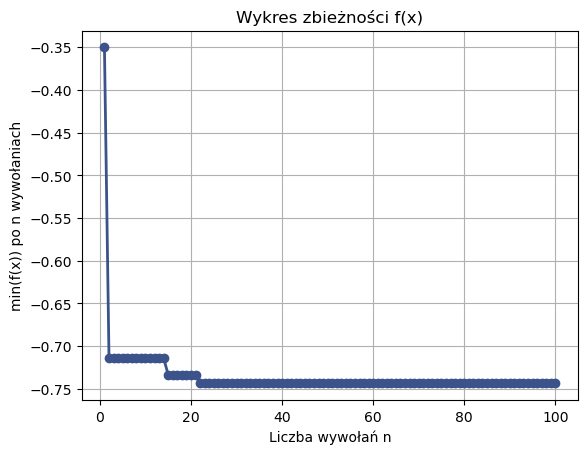

In [16]:
fig = plot_convergence(gp_)

plt.title("Wykres zbieżności f(x)")
plt.xlabel("Liczba wywołań n")
plt.ylabel("min(f(x)) po n wywołaniach")

fig.figure.savefig('wykres_zbieznosci.jpg', format='jpg', dpi=300)

plt.show()

In [17]:

iterations = range(len(gp_.func_vals))  
losses = gp_.func_vals                 
cumulative_min = np.minimum.accumulate(losses)  

data_to_save = np.column_stack((iterations, losses, cumulative_min))

file_path = "convergence_data.txt"
np.savetxt(file_path, data_to_save, delimiter=',', header="Iteration,Loss,Cumulative_Min", fmt='%.6f', comments='')

print(f"Dane zapisano do pliku: {file_path}")

Dane zapisano do pliku: convergence_data.txt


### <a name="13"></a> 13. Wykres wartość funkcji celu w każdej iteracji

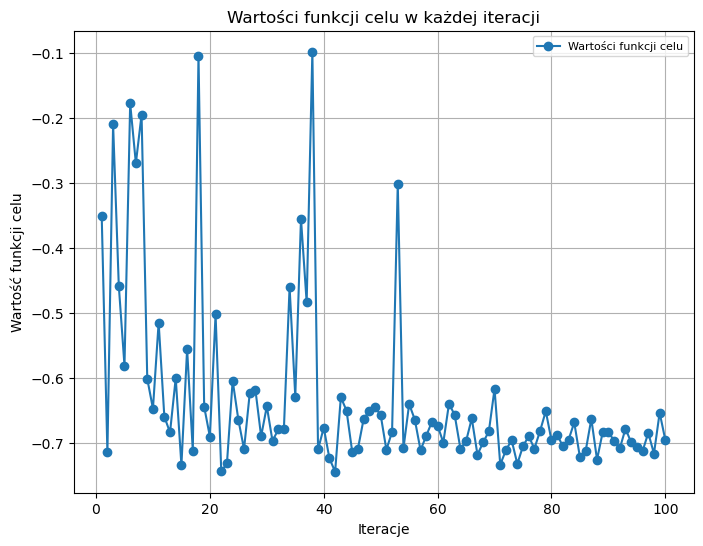

In [18]:

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(gp_.func_vals) + 1), gp_.func_vals, marker='o', label='Wartości funkcji celu')
plt.xlabel("Iteracje")
plt.ylabel("Wartość funkcji celu")
plt.title("Wartości funkcji celu w każdej iteracji")
plt.grid()
plt.legend(loc='upper right', fontsize=8)
plt.savefig('wyniki_funkcji_celu.png', dpi=300, bbox_inches='tight')

plt.show()

In [19]:
iterations = range(1, len(gp_.func_vals) + 1) 
losses = gp_.func_vals                        

data_to_save = np.column_stack((iterations, losses))

file_path = "function_values.txt"
np.savetxt(file_path, data_to_save, delimiter=',', header="Iteration,Loss", fmt='%d,%.6f', comments='')

print(f"Dane zapisano do pliku: {file_path}")

Dane zapisano do pliku: function_values.txt


### <a name="14"></a> 14.Wykres plot_objective

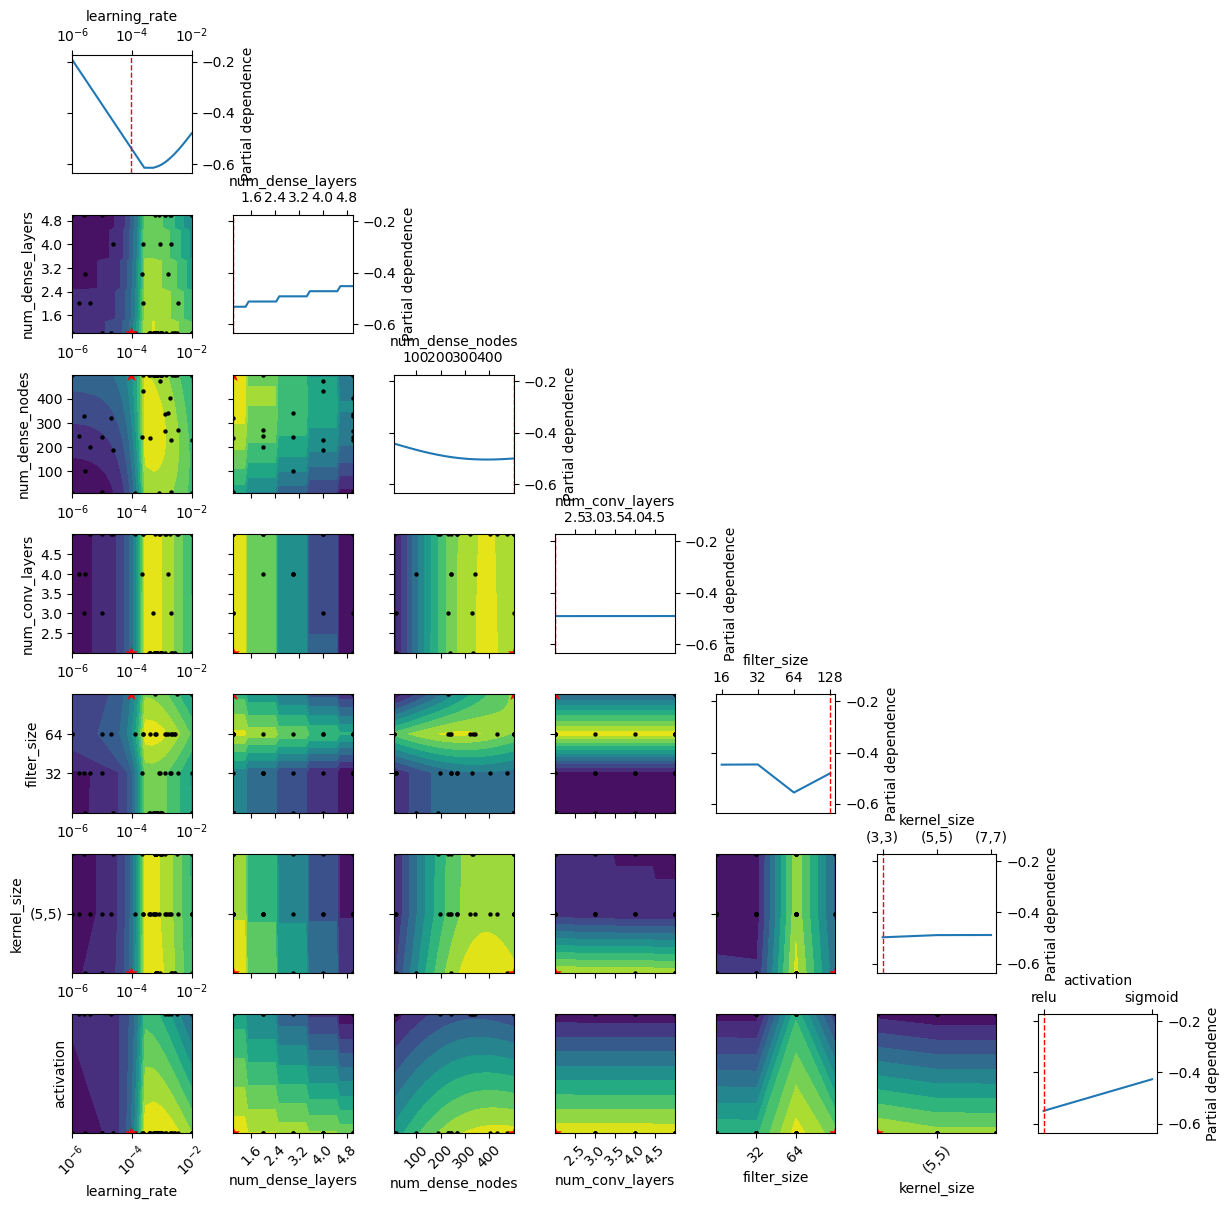

In [20]:
dim_names = [
    'learning_rate',
    'num_dense_layers',
    'num_dense_nodes',
    'num_conv_layers',
    'filter_size',
    'kernel_size',
    'activation'
]
fig2=plot_objective(result=gp_, plot_dims=dim_names)
plt.show()
fig2.figure.savefig('plot_objective.jpg', format='jpg', dpi=300)

### <a name="15"></a> 15.Wykres plot evaluations

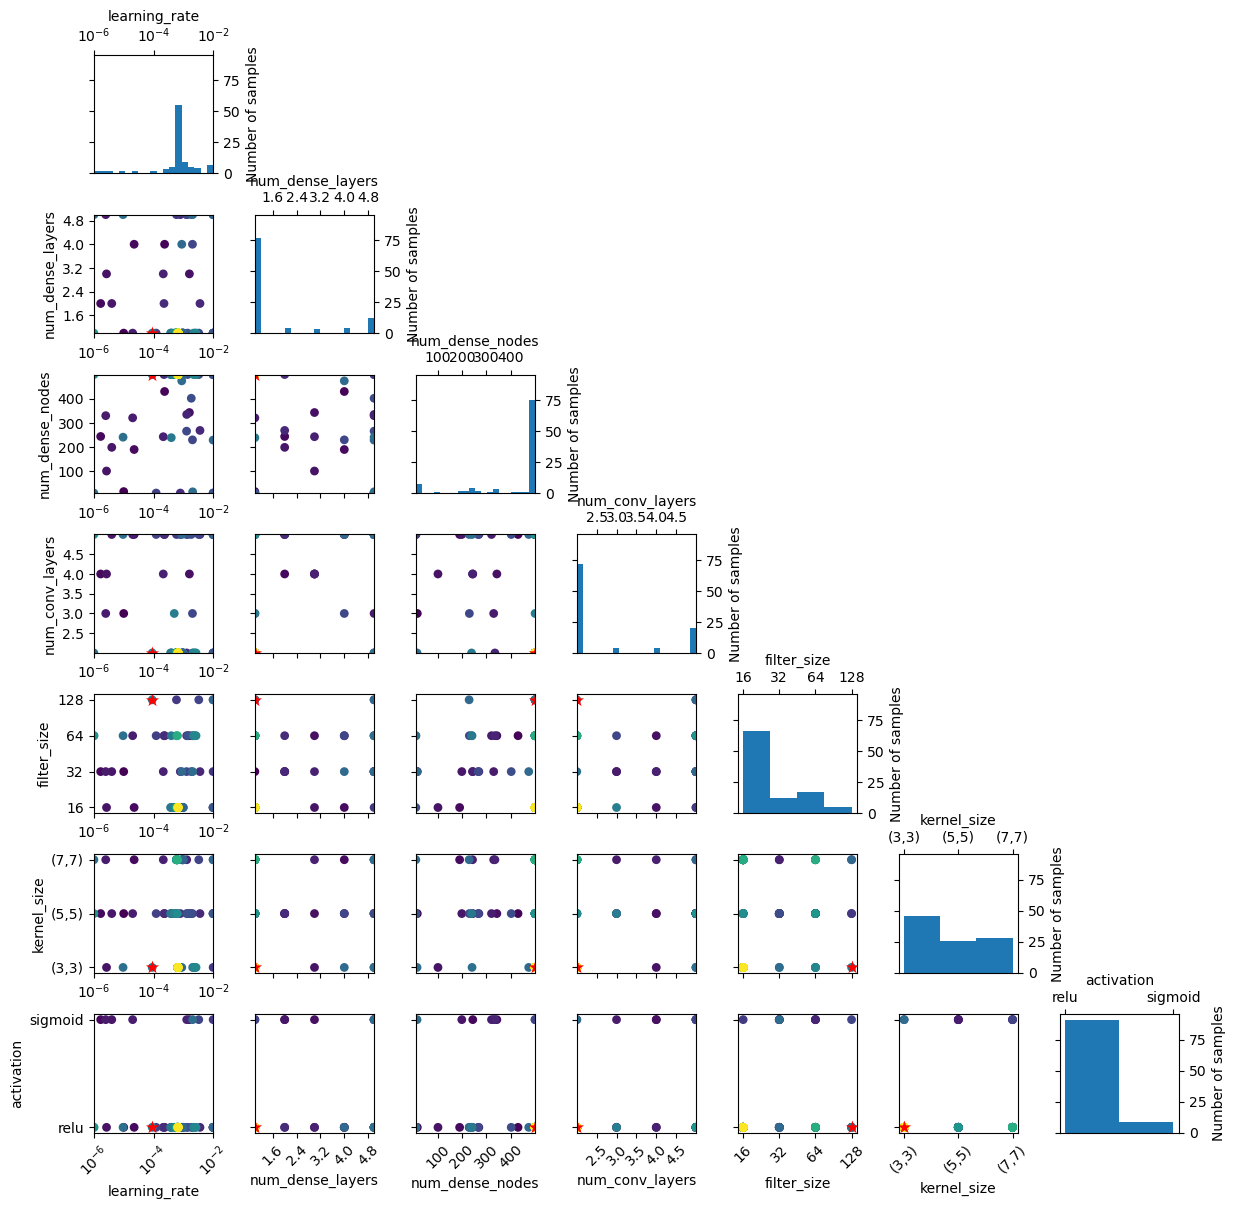

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


In [21]:
fig3=plot_evaluations(result=gp_, plot_dims=dim_names)
plt.show()
model = load_model('cnn_model.h5')
fig3.figure.savefig('plot_evaluations.jpg', format='jpg', dpi=300)
y_pred = model.predict(X_test)

y_pred_classes = np.argmax(y_pred, axis = 1)

y_true = np.argmax(y_test, axis = 1)

cm = confusion_matrix(y_true, y_pred_classes)



### <a name="16"></a> 16. Macierz pomyłek

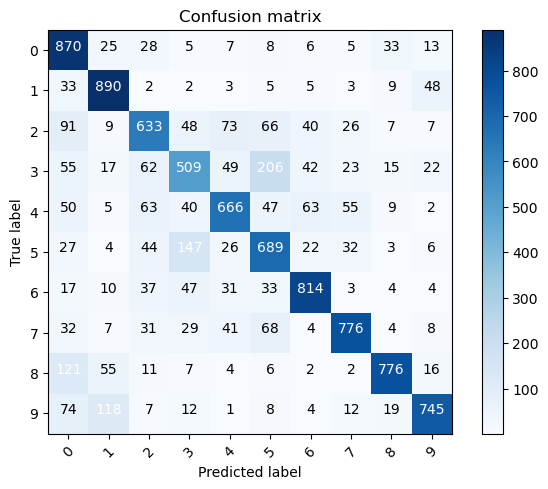

In [22]:

classes = 10

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(classes)
plt.xticks(tick_marks, range(classes), rotation=45)
plt.yticks(tick_marks, range(classes))

for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > 100 else "black",
            )

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('confusion_matrix.jpg', format='jpg', dpi=300)

### <a name="17"></a> 17. Ocena modelu na zbiorze testowym

In [23]:

model = load_model('cnn_model.h5')
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)

print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.7370 - loss: 0.1362
Test Loss: 0.13592177629470825
Test Accuracy: 0.7368000149726868
